In [8]:
import os

import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as mpanim
from IPython import display
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as tv_utils

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preparing the Dataset and Data Loader

In [9]:
DATASET_DIR = os.path.abspath("../data/images")
BATCH_SIZE = 32
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256
NUM_CHANNELS = 3
LATENT_VECTOR_SIZE = 100
GEN_FMAP_SIZE = 64
DIS_FMAP_SIZE = 64
NGPU = 1
LEARNING_RATE = 0.0002
BETA_1 = 0.5

In [10]:
dataset = datasets.ImageFolder(
    root = DATASET_DIR,
    transform = transforms.Compose([
        transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]))

In [11]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

## Example Batch

Here we'll visualize a single batch of training images,

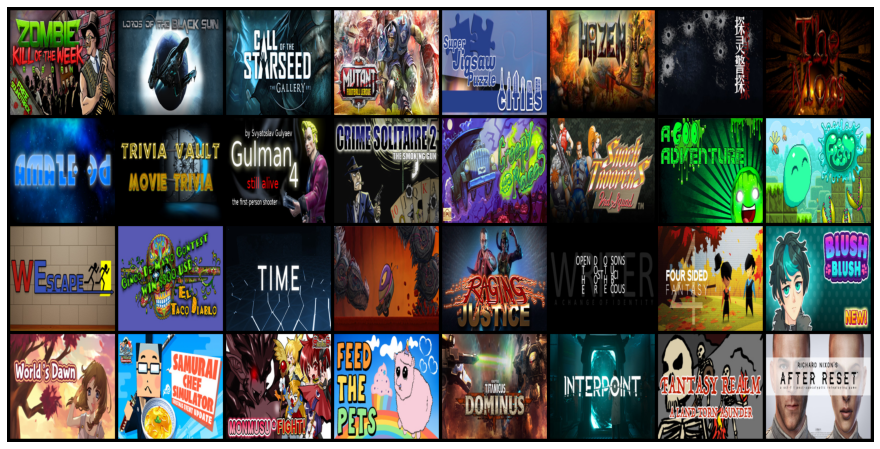

In [12]:
test_batch = next(iter(dataloader))
plt.figure(figsize=(32, 8))
plt.axis("off")

image_grid = np.transpose(tv_utils.make_grid(test_batch[0].to("cpu")[:BATCH_SIZE], padding=8, normalize=True).cpu(), (1, 2, 0))

plt.imshow(image_grid)

In [13]:
def arr_to_image(data: np.ndarray):
    return Image.fromarray((255.0 / data.max() * (data - data.min())).astype(np.uint8))

In [14]:
img = arr_to_image(image_grid.numpy())

In [15]:
img.save("tmp.jpg")

# Building the Model

This model is heavily based on the official PyTorch tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [16]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [17]:
DEBUG = True

class debug_layer(nn.Module):
    def __init__(self, enabled, prefix):
        super().__init__()
        self.enabled = enabled
        self.prefix = prefix
    
    def forward(self, x):
        if self.enabled:
            print(self.prefix, x.shape)
        return x

In [18]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(LATENT_VECTOR_SIZE, GEN_FMAP_SIZE * 64, 4, 1, 0, bias=False),
            nn.BatchNorm2d(GEN_FMAP_SIZE * 64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(GEN_FMAP_SIZE * 64, GEN_FMAP_SIZE * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GEN_FMAP_SIZE * 32),
            nn.ReLU(True),

            nn.ConvTranspose2d(GEN_FMAP_SIZE * 32, GEN_FMAP_SIZE * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GEN_FMAP_SIZE * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(GEN_FMAP_SIZE * 16, GEN_FMAP_SIZE * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GEN_FMAP_SIZE * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(GEN_FMAP_SIZE * 4, GEN_FMAP_SIZE * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GEN_FMAP_SIZE * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(GEN_FMAP_SIZE * 2, GEN_FMAP_SIZE, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GEN_FMAP_SIZE),
            nn.ReLU(True),

            nn.ConvTranspose2d(GEN_FMAP_SIZE, NUM_CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, input):
        return self.main(input)

In [19]:
net_g = Generator(NGPU).to(device)
net_g.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 4096, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(4096, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(1024, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13):

In [20]:
kernel = 4
stride = 2

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(NUM_CHANNELS, DIS_FMAP_SIZE, kernel, stride, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(DIS_FMAP_SIZE, DIS_FMAP_SIZE * 2, kernel, stride, 1, bias=False),
            nn.BatchNorm2d(DIS_FMAP_SIZE * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(DIS_FMAP_SIZE * 2, DIS_FMAP_SIZE * 4, kernel, stride, 1, bias=False),
            nn.BatchNorm2d(DIS_FMAP_SIZE * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(DIS_FMAP_SIZE * 4, DIS_FMAP_SIZE * 8, kernel, stride, 1, bias=False),
            nn.BatchNorm2d(DIS_FMAP_SIZE * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(DIS_FMAP_SIZE * 8, DIS_FMAP_SIZE * 16, kernel, stride, 1, bias=False),
            nn.BatchNorm2d(DIS_FMAP_SIZE * 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(DIS_FMAP_SIZE * 16, DIS_FMAP_SIZE * 32, kernel, stride, 1, bias=False),
            nn.BatchNorm2d(DIS_FMAP_SIZE * 32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(DIS_FMAP_SIZE * 32, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

In [21]:
net_d = Discriminator(NGPU).to(device)
net_d.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [22]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(32, LATENT_VECTOR_SIZE, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizer_d = optim.Adam(net_d.parameters(), lr=LEARNING_RATE, betas=(BETA_1, 0.999))
optimizer_g = optim.Adam(net_g.parameters(), lr=LEARNING_RATE, betas=(BETA_1, 0.999))

In [29]:
num_epochs = 5
img_list = []
g_losses = []
d_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    # Loop over batches
    for i, data in enumerate(dataloader, 0):

        # Train discriminator
        
        # Train with all-real batch
        net_d.zero_grad()

        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = net_d(real_cpu).view(-1)

        err_d_real = criterion(output, label)

        err_d_real.backward()
        D_x = output.mean().item()

        # Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, LATENT_VECTOR_SIZE, 1, 1, device=device)

        fake = net_g(noise)
        label.fill_(fake_label)

        output = net_d(fake.detach()).view(-1)

        err_d_fake = criterion(output, label)

        err_d_fake.backward()
        D_G_z1 = output.mean().item()

        err_d = err_d_real + err_d_fake
        
        optimizer_d.step()

        # Train generator
        net_g.zero_grad()
        label.fill_(real_label)

        output = net_d(fake).view(-1)

        err_g = criterion(output, label)

        err_g.backward()
        D_G_z2 = output.mean().item()
        
        optimizer_g.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     err_d.item(), err_g.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        g_losses.append(err_g.item())
        d_losses.append(err_d.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = net_g(fixed_noise).detach().cpu()
            img_grid = tv_utils.make_grid(fake, padding=2, normalize=True).cpu().numpy()
            img_grid = np.transpose(img_grid, (1, 2, 0))
            img_list.append(img_grid)
            pil_img_grid = arr_to_image(img_grid)
            pil_img_grid.save(f"../data/models/headergen/images/{epoch}-{err_g.item()}-{err_d.item()}.jpg")

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 2000 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            if min(g_losses) > err_g.item() and min(d_losses) > err_d.item():
                torch.save(net_g.state_dict(), f"../data/models/headergen/models/gen-{epoch}-{err_g.item()}.pth")
                torch.save(net_d.state_dict(), f"../data/models/headergen/models/dis-{epoch}-{err_d.item()}.pth")
            
        iters += 1

Starting Training Loop...
[0/5][0/846]	Loss_D: 97.3735	Loss_G: 0.4052	D(x): 0.9997	D(G(z)): 1.0000 / 0.9688


KeyboardInterrupt: 

In [27]:
img_grid.shape

(3, 1034, 2066)

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = mpanim.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

display.HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(tv_utils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="G")
plt.plot(d_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()